In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline

In [4]:
lat_min, lat_max = 31.1, 31.4
lon_min, lon_max = 121.3, 121.8
lat_ctr = (int)((lat_max - lat_min) / 0.005)
lon_ctr = (int)((lon_max - lon_min) / 0.005)

def lat_quantize(lat):
    return (int)((lat - lat_min) / 0.005)
def lon_quantize(lon):
    return (int)((lon - lon_min) / 0.005)

In [5]:
def extract_hist(data):
    hist, xedges, yedges = np.histogram2d(data['lat'], data['lon'],
        bins = [range(lat_ctr), range(lon_ctr)],
        range=[[0, lat_ctr], [0, lon_ctr]])
    hist = hist.astype("int")
    return hist

In [6]:
def get_density_hour(data, hour_begin, hour_end):
    data_hour = data[(hour_begin <= data['date_time']) & (data['date_time'] < hour_end)]
    data_hour['lat'] = data_hour['lat'].apply(lambda lat:
        (int)((lat-lat_min) / 0.005))
    data_hour['lon'] = data_hour['lon'].apply(lambda lon:
        (int)((lon-lon_min) / 0.005))
    data_hour = data_hour.drop_duplicates(['car_id', 'lat', 'lon'])
    hist  = extract_hist(data_hour)
    return hist

In [7]:
def get_range_density(hist, range_xy):
    center_lat = lat_quantize((range_xy[0][0] + range_xy[0][1]) / 2)
    center_lon = lon_quantize((range_xy[1][0] + range_xy[1][1]) / 2)
    return (hist[center_lat][center_lon])

In [8]:
def get_dataset(month, day):
    frames = []
    features_need = ['car_id', 'date_time', 'lat', 'lon']
    rcar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'power_mode': str,
                  'mileage': float,
                  'speed': float,
                  'fuel_consumption': float}
    ecar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'work_mode': str,
                  'mileage': float,
                  'speed': float,
                  'avg_fuel_consumption': float,
                  'system_mode': str}
    date = datetime.strftime(datetime(2017, month, day), "%Y%m%d")
    for part in range(3):
        filename = ("./data/rcar/BOT_data_rcar_{1}_{1}_part{0}.csv"
                    .format(part, date))
        data_part = pd.read_csv(filename, dtype=rcar_dtype)[features_need]
        data_part = data_part[(data_part['lat'] > 0.1) & (data_part['lon'] > 0.1)]
        frames.append(data_part)
        
        filename = ("./data/ecar/BOT_data_ecar_{1}_{1}_part{0}.csv"
                    .format(part, date))
        data_part = pd.read_csv(filename, dtype={'system_mode': str})[features_need]
        data_part = data_part[(data_part['lat'] > 0.1) & (data_part['lon'] > 0.1)]
        frames.append(data_part)
        
    data = pd.concat(frames)
    data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    return data

In [9]:
date = datetime.strftime(datetime(2017, 1, 2), "%Y%m%d")
print(date)

20170102


In [10]:
data = get_dataset()

TypeError: get_dataset() missing 2 required positional arguments: 'month' and 'day'

In [ ]:
hist = get_density_hour(data, datetime(2017, 3, 6, 9),
                       datetime(2017, 3, 6, 9+1))

In [ ]:
with h5py.File("./data/hist/test.h5", "w") as f:
    f.create_dataset('test', data=hist)

In [11]:
def store_hist():
    date = datetime(2017, 1, 2)
    delta_day = timedelta(days=1)
    while date <= datetime(2017, 1, 2):
        date_str = datetime.strftime(date, "%Y%m%d")
        with h5py.File("./data/hist/{}.h5".format(date_str), "w") as f:
            for hour in range(9, 13):
                data = get_dataset(date.month, date.day)
                hist = get_density_hour(data, datetime(2017, date.month, date.day, hour),
                                       datetime(2017, date.month, date.day, hour+1))
                f.create_dataset('hour: {}'.format(hour), data=hist)
        date += delta_day
        
store_hist()

/home/jachinshen/Projects/python/bot/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jachinshen/Projects/python/bot/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Keys: ['hour: 10', 'hour: 11', 'hour: 12', 'hour: 9']


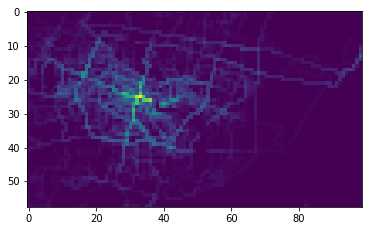

In [2]:
with h5py.File("./data/hist/20170103.h5", "r") as f:
    print("Keys: {}".format(list(f.keys())))
    data = f['hour: 9']
    plt.imshow(data)
    plt.show()